## Data Read

In [1]:
import pandas as pd
import numpy as np
import os, json, ast, gc
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix, accuracy_score
import pickle
from sklearn.preprocessing import OneHotEncoder as ohe
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt

In [2]:
def read_data(filepath):
    if not os.path.exists(filepath):
        raise FileNotFoundError(f"File not found: {filepath}")
    try:
        if filepath.endswith('.csv'):
            df = pd.read_csv(filepath)
            print(f"file loaded successfully {filepath}")
            return df
        elif filepath.endswith('.json'):
            with open(filepath, 'r', encoding ='utf-8') as f:
            #     df = json.load(f)
                df = [json.loads(line.strip()) for line in f if line.strip()]
            print(f"file loaded successfully {filepath}")
            return df
        elif filepath.endswith('.txt'):
            with open(filepath, 'r', encoding= 'utf-8') as f:
                df = f.readlines()
            print(f"file loaded successfully {filepath}")
            return df
        else:
            raise ValueError(f"File not supported, please provide csv or json: {filepath}")


    except Exception as e:
        raise Exception(f"error loading file {filepath}: {e}")

In [3]:
filepath = 'transactions.json'
content = read_data(filepath)
df = pd.DataFrame(content)
df.head(2)

file loaded successfully transactions.json


,accountNumber,customerId,creditLimit,availableMoney,transactionDateTime,transactionAmount,merchantName,acqCountry,merchantCountryCode,posEntryMode,...,echoBuffer,currentBalance,merchantCity,merchantState,merchantZip,cardPresent,posOnPremises,recurringAuthInd,expirationDateKeyInMatch,isFraud
0,737265056,737265056,5000.0,5000.0,2016-08-13T14:27:32,98.55,Uber,US,US,02,...,,0.0,,,,False,,,False,False
1,737265056,737265056,5000.0,5000.0,2016-10-11T05:05:54,74.51,AMC #191138,US,US,09,...,,0.0,,,,True,,,False,False


In [4]:
df['isFraud'].value_counts(normalize=True)

isFraud
False    0.98421
True     0.01579
Name: proportion, dtype: float64

## Data Preparation (train-test-validation) (out of time)

In [4]:
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.metrics import classification_report, roc_auc_score, confusion_matrix
import pickle
from sklearn.preprocessing import OneHotEncoder as ohe

def sequential_data_split(df, datetime_col, start_date, end_date):
    # Ensure datetime format
    df = df.copy()
    df[datetime_col] = pd.to_datetime(df[datetime_col])
    
    # Sort by datetime
    df = df.sort_values(datetime_col)

    # Convert input dates
    start_date = pd.to_datetime(start_date)
    end_date = pd.to_datetime(end_date)
    
    # Define time windows
    train_end = start_date + pd.DateOffset(months=1)
    test_end = train_end + pd.Timedelta(days=15)
    val_end = test_end + pd.Timedelta(days=15)

    # Clip val_end to not exceed dataset end
    val_end = min(val_end, end_date)

    # Split
    train = df[(df[datetime_col] >= start_date) & (df[datetime_col] < train_end)]
    test = df[(df[datetime_col] >= train_end) & (df[datetime_col] < test_end)]
    validation = df[(df[datetime_col] >= test_end) & (df[datetime_col] < val_end)]

    # Summary
    print(f"Train: {train.shape[0]} rows from {start_date.date()} to {train_end.date()}")
    print(f"Test: {test.shape[0]} rows from {train_end.date()} to {test_end.date()}")
    print(f"Validation: {validation.shape[0]} rows from {test_end.date()} to {val_end.date()}")

    # check fraud distribution in each 
    print("Train fraud distribution:", train['isFraud'].value_counts(normalize=True))
    print("Test fraud distribution:", test['isFraud'].value_counts(normalize=True))
    print("Validation fraud distribution:", validation['isFraud'].value_counts(normalize=True))

    return train, test, validation

train, test, validation = sequential_data_split(df, 'transactionDateTime', '2016-11-01', '2016-12-31')
# from sklearn.model_selection import train_test_split
# train2, test2 = train_test_split(train, test_size=0.3, random_state=44, stratify = train['isFraud'])
# print("Train fraud distribution:", train2['isFraud'].value_counts(normalize=True))
# print("Test fraud distribution:", test2['isFraud'].value_counts(normalize=True))


Train: 68097 rows from 2016-11-01 to 2016-12-01
Test: 34354 rows from 2016-12-01 to 2016-12-16
Validation: 34622 rows from 2016-12-16 to 2016-12-31
Train fraud distribution: isFraud
False    0.985917
True     0.014083
Name: proportion, dtype: float64
Test fraud distribution: isFraud
False    0.984078
True     0.015922
Name: proportion, dtype: float64
Validation fraud distribution: isFraud
False    0.98602
True     0.01398
Name: proportion, dtype: float64


## Feature Engineering

In [5]:
def create_features(df):
    df = df.copy()

    # Ensure datetime format
    df['transactionDateTime'] = pd.to_datetime(df['transactionDateTime'], errors='coerce')
    df['currentExpDate'] = pd.to_datetime(df['currentExpDate'], format='%m/%Y')
    df['accountOpenDate'] = pd.to_datetime(df['accountOpenDate'])
    df['dateOfLastAddressChange'] = pd.to_datetime(df['dateOfLastAddressChange'])

    # -------------------- DATETIME FEATURES --------------------
    df['hour'] = df['transactionDateTime'].dt.hour
    df['day'] = df['transactionDateTime'].dt.day
    df['weekday'] = df['transactionDateTime'].dt.weekday
    # df['month'] = df['transactionDateTime'].dt.month
    df['is_weekend'] = df['weekday'].isin([5,6]).astype(int)
    df['is_night'] = df['hour'].isin([0,1,2,3,4,5]).astype(int)
    # Account age at time of transaction
    df['accountAgeDays'] = (df['transactionDateTime'] - df['accountOpenDate']).dt.days
    # # Days since last address change at transaction time
    df['daysSinceAddressChange'] = (df['transactionDateTime'] - df['dateOfLastAddressChange']).dt.days
    # # Days until card expiration at transaction time
    df['daysUntilExpiration'] = (df['currentExpDate'] - df['transactionDateTime']).dt.days

    # -------------------- x-border when aq is not same as merch country --------------------
    df['is_x_border'] = np.where((df['acqCountry'] != df['merchantCountryCode']) & (df['acqCountry']!="") & (df['merchantCountryCode']!=""), 1,0)

    # -------------------- VELOCITY FEATURES --------------------
    # Transactions per account in last 1/6/24 hours
    df = df.sort_values(['accountNumber', 'transactionDateTime'])
    
    for hrs in [1, 6, 24]:
        count_col = f'txn_count_{hrs}hr'
        sum_col = f'amt_sum_{hrs}hr'
        ratio_col = f'amt_vs_avg_{hrs}hr'

        def txn_count_and_sum_last_n_hours(group):
            group = group.sort_values('transactionDateTime')
            counts = []
            sums = []

            for idx in range(len(group)):
                current_time = group.iloc[idx]['transactionDateTime']
                window_start = current_time - pd.Timedelta(hours=hrs)
                window = group[(group['transactionDateTime'] >= window_start) & (group['transactionDateTime'] < current_time)]

                counts.append(window.shape[0])
                sums.append(window['transactionAmount'].sum())

            return pd.DataFrame({
                count_col: counts,
                sum_col: sums
            }, index=group.index)

        result = (
            df.groupby('accountNumber')
            .apply(txn_count_and_sum_last_n_hours)
            .reset_index(level=0, drop=True)
        )

        # Assign results to original df
        df[count_col] = result[count_col]
        df[sum_col] = result[sum_col]
        df[ratio_col] = df['transactionAmount'] / (df[sum_col] + 1e-6)



    # -------------------- Behavioral Inconsistencies --------------------
    # Amount stats per user per day
    df['transactionDate'] = df['transactionDateTime'].dt.date
    daily_amt = df.groupby(['accountNumber', 'transactionDate'])['transactionAmount'].agg(['mean', 'sum', 'count']).reset_index()
    daily_amt.columns = ['accountNumber', 'transactionDate', 'daily_avg_amt', 'daily_total_amt', 'daily_txn_count']
    df = pd.merge(df, daily_amt, on=['accountNumber', 'transactionDate'], how='left')

    # Z-score relative to user's historical amounts
    df['user_amt_zscore'] = df.groupby('accountNumber')['transactionAmount'].transform(
        lambda x: (x - x.mean()) / x.std()
    )
    # Flag transactions > 3 standard deviations
    df['amt_outlier'] = np.where(df['user_amt_zscore'] > 3, 1,0)


    # -------------------- TIME SINCE LAST TXN --------------------
    df['time_since_last_txn'] = (
        df.groupby('accountNumber')['transactionDateTime']
        .diff().dt.total_seconds().fillna(-1)
    )
    # Time since last txn of the same merchant (fraudsters reuse merchants)
    df['time_since_same_merchant'] = (
        df.groupby(['accountNumber', 'merchantName'])['transactionDateTime']
        .diff().dt.total_seconds().fillna(-1)
    )

    # New merchant for the user (never seen before)
    df['is_new_merchant'] = (
        df.groupby('accountNumber')['merchantName']
        .transform(lambda x: ~x.duplicated(keep='first')).astype(int)
    )

    # -------------------- REPEATED AMOUNTS (possible automation/fraud) ---
    df['is_repeated_amount'] = (
        df.groupby('accountNumber')['transactionAmount']
        .transform(lambda x: x.duplicated(keep=False).astype(int))
    )

    # -------------------- MERCHANT BEHAVIOUR (RARITY SCORE) --------------------
    # rare merchantName may be linked to fraud
    merchant_freq = df['merchantName'].value_counts(normalize=True)
    df['merchant_rarity'] = df['merchantName'].map(merchant_freq)
    df['merchant_rarity'] = df['merchant_rarity'].fillna(0)
    df['is_rare_merchant'] = (df['merchant_rarity'] < 0.001).astype(int)  # tweak threshold

    # -------------------- MATCHING AMOUNT + MERCHANT REPEAT (reversals, duplicates etc.) ---
    group_cols = ['accountNumber', 'merchantName', 'transactionAmount']
    repeated_txns = df.groupby(group_cols).size().reset_index(name='same_txn_count')
    df = pd.merge(df, repeated_txns, on=group_cols, how='left')


    # -------------------- ACCOUNT USAGE PATTERN --------------------
    df['used_credit_ratio'] = (df['creditLimit'] - df['availableMoney']) / df['creditLimit']
    df['balance_ratio'] = df['currentBalance'] / df['creditLimit']

    # --------------------ACCOUNT SEGMENT --------------------
    bins = [0, 10000, 15000, 20000, float('inf')]
    labels = ['lessthan10k', '10to15k', '15to20k', 'greaterthan20k']
    df['credit_segment'] = pd.cut(df['creditLimit'], bins=bins, labels=labels, right=False)

    #------------------- Last 4 digit features -----------
    last4_freq = df['cardLast4Digits'].value_counts()
    df['last4_freq'] = df['cardLast4Digits'].map(last4_freq)

    rare_last4 = df['cardLast4Digits'].value_counts()[lambda x: x < 10].index
    df['last4_is_rare'] = df['cardLast4Digits'].isin(rare_last4).astype(int)

    # Does last4 change unusually for a user? Sudden change = suspicious.
    df['last4_change'] = (
    df.groupby('accountNumber')['cardLast4Digits']
    .transform(lambda x: x != x.shift())
    .astype(int)
    )

    # Cleanup temp columns
    df.drop(columns=['transactionDate'], inplace=True)

    return df


In [ ]:
train_f = create_features(train)
test_f = create_features(test)
print(f"train shape--> {train.shape}", f"train shape after features --> {train_f.shape}")
print(f"test shape--> {test.shape}", f"test shape after features --> {test_f.shape}")
display(train_f.head(2))
additional_cols = set(train_f.columns)-set(train.columns)
print("additional columns in train_f compared to train:", len(additional_cols))
print(additional_cols)
train_f.to_parquet("train_f_cat.parquet", index=False)
test_f.to_parquet("test_f_cat.parquet", index=False)
del df
gc.collect()

C:\Users\HIMANSHU\AppData\Local\Temp\ipykernel_6460\292811895.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby('accountNumber')
C:\Users\HIMANSHU\AppData\Local\Temp\ipykernel_6460\292811895.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df.groupby('accountNumber')
C:\Users\HIMANSHU\AppData\Local\Temp\ipykernel_6460\292811895.py:55: DeprecationWarning: DataFrameGroupBy.apply operated on 

## Data Transformation

In [ ]:
def transform_data_catboost(data, primary_id, target_column, exclude_cols, cat_cols, num_cols, date_cols):
    data['transactionDateTime'] = pd.to_datetime(data['transactionDateTime'])
    data = data.sort_values(by=['transactionDateTime']).reset_index(drop=True)

    # Drop unnecessary columns
    X = data.drop(columns=primary_id + exclude_cols + date_cols + [target_column], errors='ignore')
    y = data[target_column]

    return X, y

cat_cols = ['acqCountry','merchantCountryCode','posEntryMode','posConditionCode','merchantCategoryCode', 'merchantName',
            'transactionType', 'cardPresent','cardCVV', 'enteredCVV', 'cardLast4Digits'] +   ['day', 'credit_segment',
                            'hour', 'is_rare_merchant',  'is_repeated_amount', 'is_weekend', 'weekday']

exclude_cols = ['echoBuffer', 'merchantCity', 'merchantState', 'merchantZip', 'posOnPremises', 'recurringAuthInd'] + ['is_new_merchant', 
                     'last4_is_rare', 'expirationDateKeyInMatch',  'is_x_border' ] + ['txn_count_1hr'+'balance_ratio'+'amt_outlier'+'last4_change'+'is_night']

num_cols = ['creditLimit', 'availableMoney', 'transactionAmount', 'currentBalance'] + ['daily_avg_amt',  
'accountAgeDays', 'amt_vs_avg_6hr',  'daysSinceAddressChange', 'daily_txn_count', 
 'merchant_rarity', 'amt_vs_avg_24hr', 'used_credit_ratio', 'txn_count_6hr', 'amt_vs_avg_1hr', 
'daily_total_amt', 'time_since_last_txn',  'daysUntilExpiration', 
 'amt_sum_1hr', 'txn_count_24hr', 'amt_sum_6hr', 'same_txn_count', 'user_amt_zscore', 
'amt_sum_24hr', 'time_since_same_merchant', 'last4_freq']

primary_id = ['accountNumber', 'customerId']
date_cols = ['transactionDateTime', 'currentExpDate', 'accountOpenDate', 'dateOfLastAddressChange']
target_column = 'isFraud'
print(len(cat_cols+exclude_cols+num_cols+primary_id+date_cols+[target_column]))

Xtraincat, ytraincat = transform_data_catboost(train_f, primary_id, target_column, exclude_cols, cat_cols, num_cols, date_cols)
Xtestcat, ytestcat = transform_data_catboost(test_f, primary_id, target_column, exclude_cols, cat_cols, num_cols,date_cols) 

61


## Model Building with loss monitoring b/w train and test

0:	learn: 0.7020314	test: 0.7114415	best: 0.7114415 (0)	total: 177ms	remaining: 5m 54s
100:	learn: 0.8040156	test: 0.8188673	best: 0.8192328 (93)	total: 14.2s	remaining: 4m 27s
200:	learn: 0.8219795	test: 0.8412199	best: 0.8412561 (198)	total: 29.2s	remaining: 4m 21s
300:	learn: 0.8289425	test: 0.8480952	best: 0.8480952 (300)	total: 44.1s	remaining: 4m 9s
400:	learn: 0.8335110	test: 0.8512489	best: 0.8513029 (397)	total: 58.2s	remaining: 3m 51s
500:	learn: 0.8380950	test: 0.8530143	best: 0.8530811 (491)	total: 1m 12s	remaining: 3m 36s
600:	learn: 0.8417411	test: 0.8549642	best: 0.8549930 (586)	total: 1m 25s	remaining: 3m 19s
700:	learn: 0.8456387	test: 0.8556754	best: 0.8557093 (690)	total: 1m 40s	remaining: 3m 6s
800:	learn: 0.8491876	test: 0.8562827	best: 0.8563893 (777)	total: 1m 54s	remaining: 2m 51s
900:	learn: 0.8525884	test: 0.8574583	best: 0.8574583 (900)	total: 2m 9s	remaining: 2m 38s
1000:	learn: 0.8560687	test: 0.8578796	best: 0.8578822 (996)	total: 2m 24s	remaining: 2m 23s


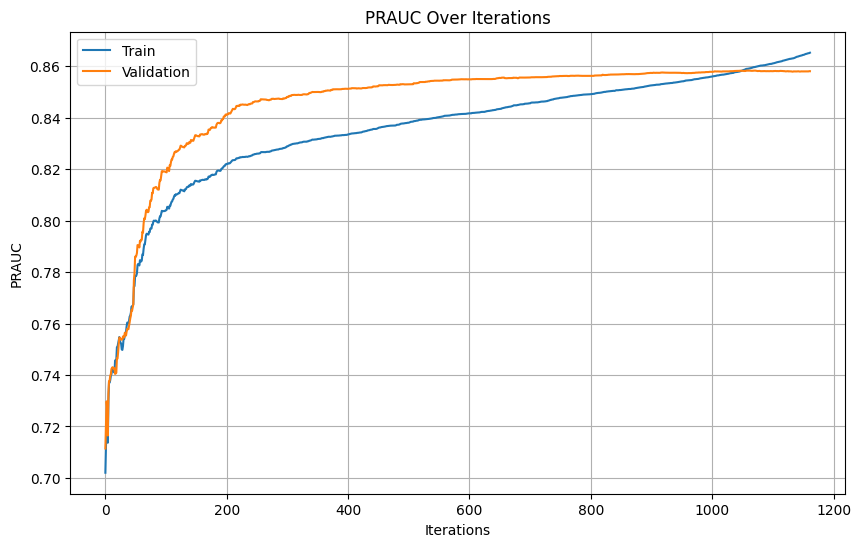

Best Threshold = 0.8332
Best F1 = 0.2654, Precision = 0.3901, Recall = 0.2011
AUC-PR = 0.2127
Test Accuracy: 0.9822


In [ ]:
import matplotlib.pyplot as plt
#accuracy_score
from catboost import CatBoostClassifier, Pool
from sklearn.metrics import (
    precision_recall_curve, average_precision_score, accuracy_score
)
import numpy as np

def train_catboost(Xtrain, ytrain, Xtest, ytest, params, cat_features=None):
    # Initialize model with unpacked params
    model = CatBoostClassifier(**params)

    # Pool conversion for CatBoost
    train_pool = Pool(Xtrain, label=ytrain, cat_features=cat_features)
    test_pool = Pool(Xtest, label=ytest, cat_features=cat_features)

    # Fit with evaluation set
    model.fit(train_pool, eval_set=test_pool, use_best_model=True)

    # Get evaluation results (for plotting)
    evals = model.get_evals_result()
    metric_name = list(evals['validation'].keys())[1]  # Should match eval_metric
    print(evals['validation'].keys())

    # Plot training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(evals['learn'][metric_name], label='Train')
    plt.plot(evals['validation'][metric_name], label='Validation')
    plt.xlabel('Iterations')
    plt.ylabel(metric_name)
    plt.title(f'{metric_name} Over Iterations')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Predict probabilities
    y_pred_prob = model.predict_proba(Xtest)[:, 1]

    # PR-AUC & best threshold
    precision, recall, thresholds = precision_recall_curve(ytest, y_pred_prob)
    fscore = 2 * precision * recall / (precision + recall + 1e-6)
    ix = np.argmax(fscore)
    best_threshold = thresholds[ix]

    print(f"Best Threshold = {best_threshold:.4f}")
    print(f"Best F1 = {fscore[ix]:.4f}, Precision = {precision[ix]:.4f}, Recall = {recall[ix]:.4f}")
    print(f"AUC-PR = {average_precision_score(ytest, y_pred_prob):.4f}")
    print(f"Test Accuracy: {accuracy_score(ytest, (y_pred_prob > best_threshold).astype(int)):.4f}")
    # print(f"Test ROC AUC: {roc_auc_score(ytest, y_pred_prob):.4f}")

    return model, best_threshold

scale_pos_weight = ytraincat.shape[0] / ytraincat.sum() - 1
params = {
    'iterations': 2000,
    'learning_rate': 0.01,
    'depth': 5,
    'eval_metric': 'PRAUC',
    'early_stopping_rounds': 100,
    'verbose': 100,
    'random_seed': 42,
    'scale_pos_weight': scale_pos_weight
}
model, best_threshold = train_catboost(Xtraincat, ytraincat, Xtestcat, ytestcat,params, cat_features=cat_cols)

## Model performance evaluation (detailed)

    Threshold  Accuracy  Precision    Recall  F1-score   ROC-AUC    PR-AUC
0        0.01  0.015922   0.015922  1.000000  0.031346  0.840887  0.212215
1        0.02  0.015981   0.015923  1.000000  0.031348  0.840887  0.212215
2        0.03  0.016446   0.015931  1.000000  0.031362  0.840887  0.212215
3        0.04  0.018659   0.015966  1.000000  0.031430  0.840887  0.212215
4        0.05  0.024597   0.016062  1.000000  0.031616  0.840887  0.212215
..        ...       ...        ...       ...       ...       ...       ...
93       0.94  0.984776   0.800000  0.058501  0.109029  0.840887  0.212215
94       0.95  0.984572   0.793103  0.042048  0.079861  0.840887  0.212215
95       0.96  0.984602   1.000000  0.032907  0.063717  0.840887  0.212215
96       0.97  0.984310   1.000000  0.014625  0.028829  0.840887  0.212215
97       0.98  0.984107   1.000000  0.001828  0.003650  0.840887  0.212215

[98 rows x 7 columns]


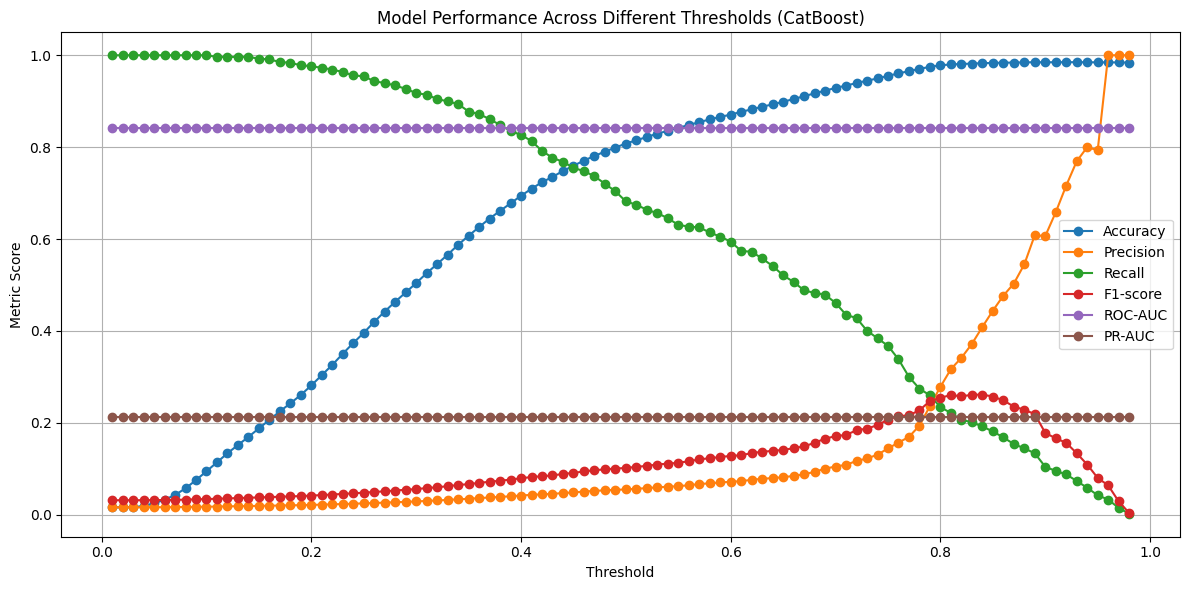

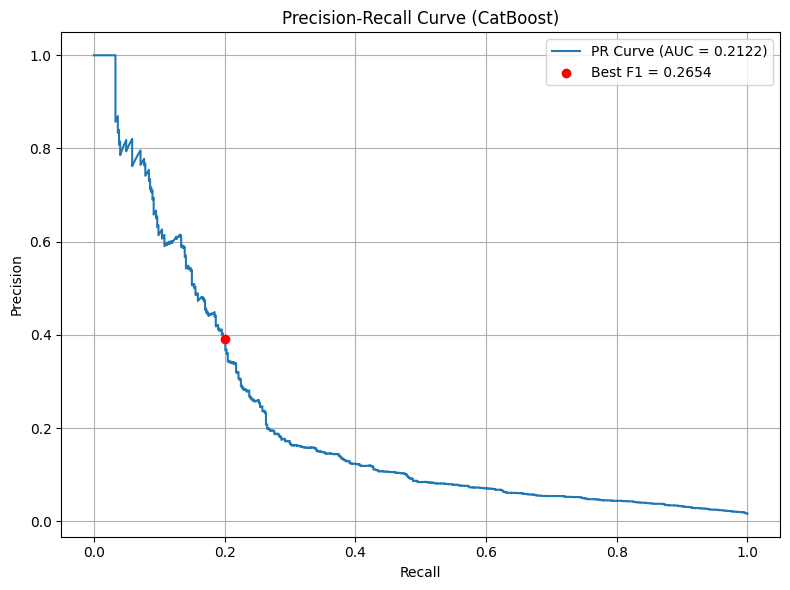


🔍 Best F1 Score: 0.2654 at Threshold: 0.8332


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, precision_recall_curve, auc


def evaluate_thresholds_catboost(model, X_test, y_test):
    """
    Evaluate CatBoost classification metrics across thresholds and plot PR curve.
    """
    # Get probabilities for positive class
    y_pred_probs = model.predict_proba(X_test)[:, 1]
    thresholds = np.arange(0.1, 1.0, 0.1)

    results = []
    for threshold in thresholds:
        y_pred_binary = (y_pred_probs > threshold).astype(int)

        precision, recall, f1, _ = precision_recall_fscore_support(
            y_test, y_pred_binary, average='binary', zero_division=0
        )
        accuracy = (y_test == y_pred_binary).mean()
        roc_auc = roc_auc_score(y_test, y_pred_probs)

        results.append((threshold, accuracy, precision, recall, f1, roc_auc))

    # Results table
    results_df = pd.DataFrame(results, columns=['Threshold', 'Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC'])
    print(results_df)

    # Plot metrics over thresholds
    results_df.set_index('Threshold')[['Accuracy', 'Precision', 'Recall', 'F1-score', 'ROC-AUC']].plot(
        figsize=(10, 5), marker='o', grid=True
    )
    plt.title("Model Performance Across Different Thresholds (CatBoost)")
    plt.ylabel("Metric Score")
    plt.xlabel("Threshold")
    plt.legend(loc='best')
    plt.show()

    # PR Curve
    precision_curve, recall_curve, pr_thresholds = precision_recall_curve(y_test, y_pred_probs)
    f1_scores = 2 * (precision_curve * recall_curve) / (precision_curve + recall_curve + 1e-8)
    best_f1_index = np.argmax(f1_scores)
    best_f1 = f1_scores[best_f1_index]

    plt.figure(figsize=(8, 6))
    plt.plot(recall_curve, precision_curve, label=f'PR Curve (AUC = {auc(recall_curve, precision_curve):.4f})')
    plt.scatter(recall_curve[best_f1_index], precision_curve[best_f1_index],
                color='red', label=f'Best F1 = {best_f1:.4f}', zorder=5)
    plt.title("Precision-Recall Curve (CatBoost)")
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.grid(True)
    plt.legend()
    plt.show()

    return results_df

results_df = evaluate_thresholds_catboost(model, Xtestcat, ytestcat)

In [ ]:
with open('cat_model_baseline.pkl', 'wb') as f:
    pickle.dump(model, f)

## Feature importance (both best and worst features for recursive feature reduction)

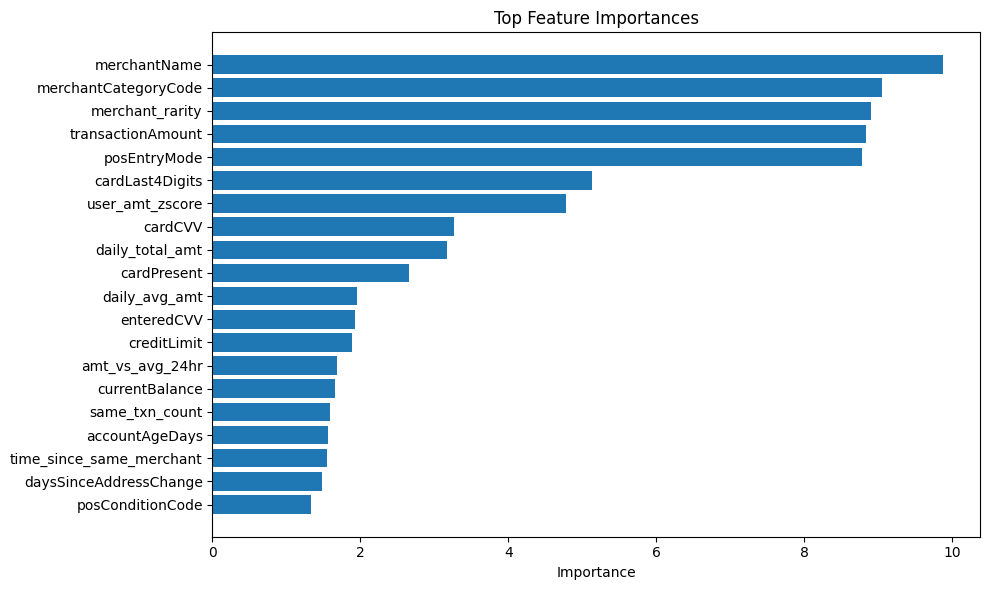

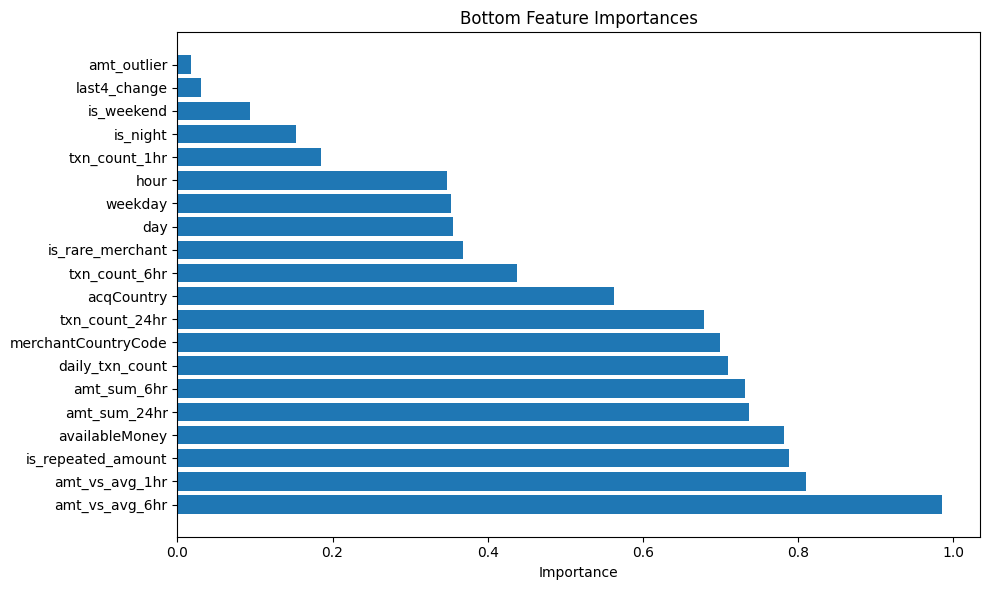

In [ ]:
import matplotlib.pyplot as plt

def plot_feature_importance(model, X, top_n=20):
    feature_importance = model.get_feature_importance()
    feature_names = X.columns

    # Get top features
    top_indices = np.argsort(feature_importance)[::-1][:top_n]

    plt.figure(figsize=(10, 6))
    plt.barh(np.array(feature_names)[top_indices][::-1],
             np.array(feature_importance)[top_indices][::-1])
    plt.title("Top Feature Importances")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

def plot_least_important_features(model, X, bottom_n=20):
    feature_importance = model.get_feature_importance()
    feature_names = X.columns

    # Get bottom features
    bottom_indices = np.argsort(feature_importance)[:bottom_n]

    plt.figure(figsize=(10, 6))
    plt.barh(np.array(feature_names)[bottom_indices][::-1],
             np.array(feature_importance)[bottom_indices][::-1])
    plt.title("Bottom Feature Importances")
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

plot_feature_importance(model, Xtraincat, top_n=20)
plot_least_important_features(model, Xtraincat, bottom_n=20)

plot_feature_importance(model, Xtestcat, top_n=20)
plot_least_important_features(model, Xtestcat, bottom_n=20)

## The End

## Hyperparameter Tuning

In [ ]:
import optuna
from sklearn.metrics import precision_recall_curve, average_precision_score

def objective(trial):
    params = {
        'iterations': trial.suggest_categorical('iterations', [2000]),
        'learning_rate': trial.suggest_float('learning_rate', 0.01, 0.2, log=True),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1e-2, 10.0),
        'border_count': trial.suggest_categorical('border_count', [32, 64, 128]),
        'grow_policy': trial.suggest_categorical('grow_policy', ['SymmetricTree', 'Lossguide']),
        'scale_pos_weight': trial.suggest_float('scale_pos_weight', 50, 200),
        'eval_metric': 'PRAUC',
        'early_stopping_rounds': 100,
        'random_seed': 42,
        'verbose': False
    }
    
    model = CatBoostClassifier(**params)
    model.fit(train_pool, eval_set=val_pool)
    
    # Predict on validation set
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    prauc = average_precision_score(y_val, y_pred_proba)
    
    return prauc  # Maximize PR-AUC

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=50)  # Adjust trials based on compute resources

print("Best hyperparameters:", study.best_params)
print("Best PR-AUC:", study.best_value)

In [ ]:
best_params = study.best_params
best_params.update({'early_stopping_rounds': 100, 'eval_metric': 'PRAUC'})

# Retrain on full training data (Xtraincat/ytraincat) with best params
final_model = CatBoostClassifier(**best_params)
final_model.fit(
    Pool(Xtraincat, ytraincat, cat_features=cat_cols),
    eval_set=Pool(Xtestcat, ytestcat, cat_features=cat_cols)
)

# Evaluate on test set
y_pred_proba = final_model.predict_proba(Xtestcat)[:, 1]
precision, recall, _ = precision_recall_curve(ytestcat, y_pred_proba)
print(f"Test PR-AUC: {average_precision_score(ytestcat, y_pred_proba):.4f}")